In [1]:
import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util

from functools import partial
import time
from typing import List

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))

  
key = random.PRNGKey(0)

# There is currently an integer cast in the jax md neighbor-list function
# that causes a warning.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Replicating Lennard-Jones potential with UF2

## Defining the system

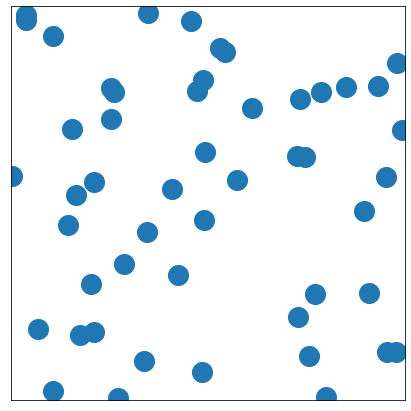

In [2]:
N = 50
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 


plot_system(R,box_size)

In [3]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

In [5]:
from scipy.spatial.distance import cdist
positions = []

N = 50
dimension = 3
box_size = 12.0

n = 50


while True:
    key, split = random.split(key)
    R_i = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64)
    d = cdist(R_i,R_i)
    minimum = min(d[d!=0.0])
    
    if minimum < 1.5:
        continue
    positions.append(R_i)
    if len(positions) >= n:
        break

Rs = jnp.stack(positions)

In [6]:
Rs.shape

(50, 50, 3)

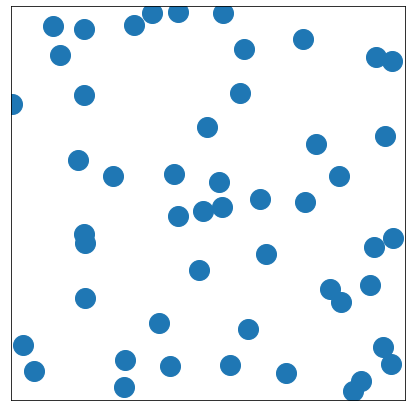

In [7]:
plot_system(Rs[0],box_size)

## Lennard-Jones

In [8]:
from jax_md.energy import lennard_jones_neighbor_list

In [9]:
lj_nf, lj_energy = lennard_jones_neighbor_list(displacement, box, sigma=1.6, epsilon=0.1, r_cutoff=5.5)

In [10]:
nbrs_lj = lj_nf.allocate(R)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [11]:
nbrs_lj.idx.shape

(2, 1523)

In [12]:
lj_energy(R, nbrs_lj)

DeviceArray(7.39008878e+09, dtype=float64)

In [13]:
- grad(lj_energy)(R, nbrs_lj)[:5,:]

DeviceArray([[-2.83653725e-02, -4.32992993e-02, -1.60750992e-03],
             [-9.38252246e+00,  5.46323684e+00,  4.14829746e+00],
             [-2.85209072e-01,  2.31037810e+00,  2.06541900e+01],
             [ 2.36696876e+01, -4.68510379e+00,  4.67605659e+00],
             [ 1.14429592e+04,  4.36799810e+03, -8.94516343e+03]],            dtype=float64)

## UF2

In [14]:
from uf3.jax.potentials import uf3_neighbor

In [15]:
knots = [jnp.asarray([1.5 , 1.5 , 1.5 , 1.5 , 1.66, 1.82, 1.98, 2.14, 2.3 , 2.46, 2.62, 2.78, 2.94, 3.1 , 3.26, 3.42, 3.58, 3.74, 3.9 , 4.06, 4.22, 4.38, 4.54, 4.7 , 4.86, 5.02, 5.18, 5.34, 5.5 , 5.5 , 5.5 , 5.5 ])]

In [16]:
# knots = [jnp.pad(jnp.linspace(1.0,5.5,25),(3,3),"edge")]
coefficients = [jnp.zeros(len(knots[0])-4)]

In [17]:
knots

[DeviceArray([1.5 , 1.5 , 1.5 , 1.5 , 1.66, 1.82, 1.98, 2.14, 2.3 , 2.46,
              2.62, 2.78, 2.94, 3.1 , 3.26, 3.42, 3.58, 3.74, 3.9 , 4.06,
              4.22, 4.38, 4.54, 4.7 , 4.86, 5.02, 5.18, 5.34, 5.5 , 5.5 ,
              5.5 , 5.5 ], dtype=float64)]

In [18]:
uf2_nf, uf2_energy = uf3_neighbor(displacement, box, knots=[knots], coefficients=coefficients, cutoff=5.5)

In [19]:
nbrs_uf2 = uf2_nf.allocate(R, extra_capacity=10)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [20]:
uf2_energy = jit(uf2_energy)
uf2_energy(R, nbrs_uf2)

DeviceArray(0., dtype=float64)

## Loss function

In [21]:
from uf3.jax.physical import stress_neighborlist_fn
from uf3.regression.regularize import get_regularizer_matrix

In [22]:
def ufp_reference(R, energy_fn, neighborlist_fn, box):
    nbrs = neighborlist_fn.allocate(R)
    stress = stress_neighborlist_fn(energy_fn, box)
    def reference(R, params):
        _neighbor = neighborlist_fn.update(R, nbrs)
        E = energy_fn(R, _neighbor, coefficients=params)
        F = - grad(energy_fn)(R, _neighbor, coefficients=params)
        S = stress(R, _neighbor, coefficients=params)
        return (E,F,S)

    return vmap(reference, (0, None))

def lj_reference(R, energy_fn, neighborlist_fn, box):
    nbrs = neighborlist_fn.allocate(R)
    stress = stress_neighborlist_fn(energy_fn, box)
    def reference(R):
        _neighbor = neighborlist_fn.update(R, nbrs)
        E = energy_fn(R, _neighbor) * 2
        F = - grad(energy_fn)(R, _neighbor) * 2
        S = stress(R, _neighbor) * 2
        return (E,F,S)

    return vmap(reference)

def regularize(coefficients, ridge=1.0, curvature=1.0):
    return jnp.sum(
        jnp.einsum(
            "ij,j->i",
            get_regularizer_matrix(len(coefficients), ridge=ridge, curvature=curvature),
            coefficients,
        )
        ** 2
    )

def ufp_loss(params, R, targets, weights, reference_fn):
    tE, tF, tS = targets
    E, F, S = reference_fn(R, params)

    n_systems = len(tE)
    n_atoms = len(tF[0])
    
    E_loss = jnp.sum((tE - E)**2) / (n_systems * jnp.var(tE))
    F_loss = jnp.sum((tF - F)**2) / (n_systems * n_atoms * jnp.var(tF))
    S_loss = jnp.sum((tS - S)**2) / jnp.var(tS)#(len(tS) * jnp.var(tS))
    reg = regularize(params[0])

    return weights[0] * E_loss + weights[1] * F_loss + weights[2] * S_loss + weights[3] * reg



In [23]:
lj_rf = lj_reference(R, lj_energy, lj_nf, box)
targets = lj_rf(Rs)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [24]:
uf2_ref = ufp_reference(R, uf2_energy, uf2_nf, box)
loss = grad(ufp_loss)(coefficients, Rs, targets, [.5,0.5,0.0,0.05], uf2_ref)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [25]:
targets[0].shape

(50,)

## Training

In [28]:
from uf3.jax.potentials import uf2_interaction

uf2_fn = uf2_interaction(knots)
uf2 = lambda drs, co: vmap(partial(uf2_fn, coefficients=co))(drs)

Error after 0 iterations: 2.606430531419427
Error after 100 iterations: nan
Error after 200 iterations: nan


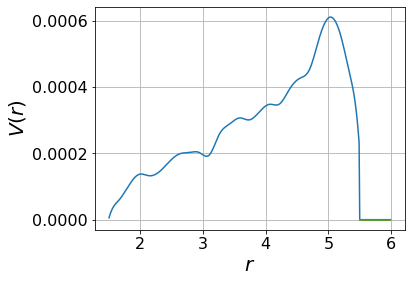

In [62]:
params =  [jnp.zeros(len(knots[0])-4)]
rate = 1e3
hyperparameters = [0.2,0.8,0.0,0.05]

@jit
def loss_fn(params, R, labels):
    return ufp_loss(params, R, labels, hyperparameters, uf2_ref)

for i in range(201):
    # params, opt_state = update_step(params, opt_state, Rs, targets)
    delta = grad(loss_fn)(params, Rs, targets)
    params[0] -= delta[0] * rate

    if i % 100 == 0:
        error = ufp_loss(params, Rs, targets, hyperparameters, uf2_ref)
        print(f"Error after {i} iterations: {error}")

        ref = jnp.arange(1.5,6.0,0.01)
        U = uf2(ref, params[0])
        plt.plot(ref,U)

format_plot(r'$r$', r'$V(r)$')
finalize_plot()
# plt.savefig('system_balanced_centric.png')

In [63]:
grad(loss_fn)(params, Rs, targets)

[DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan], dtype=float64)]

In [48]:
A = [0,0,0]
A[0] = params[0]

In [53]:
A[1] = params[0]

In [56]:
A[2] = params[0]

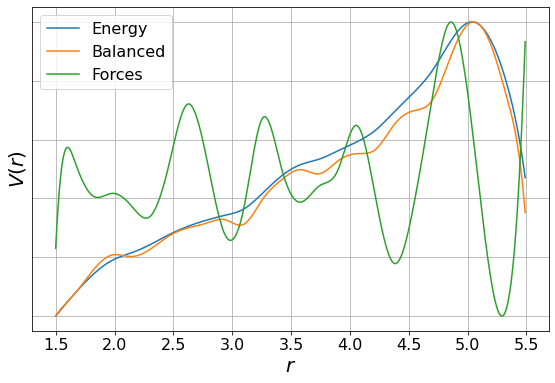

In [73]:
def Norm(data):
    return (data - onp.min(data)) / (onp.max(data) - onp.min(data))


drs = jnp.arange(1.5,5.5,0.01)
U1 = uf2(drs, A[0])
U2 = uf2(drs, A[1])
U3 = uf2(drs, A[2])
plt.plot(drs, Norm(U1), label="Energy")
plt.plot(drs,Norm(U2), label="Balanced")
plt.plot(drs,Norm(U3), label="Forces")
format_plot(r'$r$', r'$V(r)$')
plt.legend()
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelleft=False)
shape=(1, 0.7)
plt.gcf().set_size_inches(
    shape[0] * 2. * plt.gcf().get_size_inches()[1], 
    shape[1] * 2. * plt.gcf().get_size_inches()[1])
plt.tight_layout()
plt.savefig('system_gd_result.png')

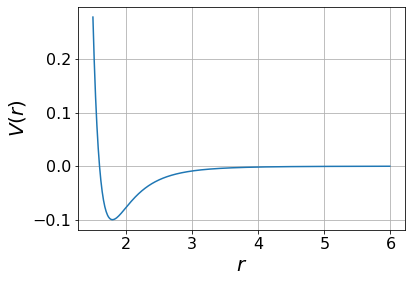

In [32]:
from jax_md.energy import lennard_jones

drs = jnp.arange(1.5,6.0,0.01)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()